In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

import torch
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.models import resnet34
from torch.utils.data import DataLoader

from sklearn.metrics import confusion_matrix, f1_score
import math
from tqdm import tqdm

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [30]:
# convert data to a normalized torch.FloatTensor
# transform = transforms.Compose([    transforms.ToTensor(), transforms.Normalize(
#         mean=[0.4914, 0.4822, 0.4465],
#         std=[0.2023, 0.1994, 0.2010])
# ])

# # convert data to a normalized torch.FloatTensor
# transform = transforms.Compose([
#     transforms.Resize((224, 224)), # Resize to 224x224 (height x width)
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                           std=[0.229, 0.224, 0.225])
# ])
transform = transforms.Compose([
    transforms.Resize((128, 128)), # Resize to 224x224 (height x width)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])


In [31]:
# loading the train data
batch_size = 32
#drop_last=True
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
train_dataloader = DataLoader(train_data, batch_size=batch_size,shuffle=True )

#loading the test data
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False )


Files already downloaded and verified
Files already downloaded and verified


### Dense (fully connected) layer

In [32]:
class Dense:
    def __init__(self, n_inputs, n_neurons):
        # He Weight Initialization
        self.weights = torch.randn(n_inputs, n_neurons) * torch.sqrt(torch.tensor(2. / n_inputs))
        self.biases = torch.zeros((1, n_neurons))
        self.weights = self.weights.to(device)
        self.biases = self.biases.to(device)
        self.prev_wchange = torch.zeros((n_inputs, n_neurons))
        self.prev_bchange = torch.zeros((1, n_neurons))
        self.prev_wchange = self.prev_wchange.to(device)
        self.prev_bchange = self.prev_bchange.to(device)

    
    def forward(self, inputs):
        self.inputs = inputs
        self.inputs = self.inputs.to(device)
        return torch.matmul(self.inputs, self.weights) + self.biases

    def backward(self, output_error):
        # calculating errors
        self.inputs_error = torch.matmul(output_error, self.weights.T)
        self.inputs_error = self.inputs_error.to(device)
        self.weights_grad = torch.matmul(self.inputs.T, output_error)
        self.weights_grad = self.weights_grad.to(device)
        self.biases_grad = torch.sum(output_error, axis=0, keepdims=True)
        self.biases_grad =  self.biases_grad.to(device)
        return self.inputs_error


### Activation Layers


In [33]:
class ReLU:
    def forward(self, inputs):
        self.inputs = inputs.clone()
        self.inputs = self.inputs.to(device)
        return torch.maximum(torch.zeros_like(inputs), inputs)

    def backward(self, output_error):
        self.inputs_error = output_error.clone()
        self.inputs_error = self.inputs_error.to(device)
        self.inputs_error[self.inputs <= 0] = 0
        return self.inputs_error


In [34]:
class Sigmoid:
    def forward(self,inputs):
        self.outputs = 1 / (1 + np.exp(-inputs))
        self.outputs.to(device)
        return self.outputs

    def backward(self,output_error):
        self.outputs_grad = output_error * (1-self.outputs) * self.outputs
        self.outputs_grad = self.outputs_grad.to(device)
        return self.outputs_grad

In [35]:
class Softmax:
    def forward(self, inputs):
        self.inputs = inputs.clone()
        self.inputs = self.inputs.to(device)
        exp_inputs = torch.exp(self.inputs - torch.max(self.inputs, dim=1, keepdim=True).values)
        exp_inputs = exp_inputs.to(device)
        self.outputs = exp_inputs / torch.sum(exp_inputs, dim=1, keepdim=True)
        self.outputs = self.outputs.to(device)
        return self.outputs



### Loss function

In [36]:
class Categorical_Cross_Entropy_loss:
    
    def forward(self, softmax_output, class_label):
        # Apply softmax function to the output
        self.softmax_output = torch.clamp(softmax_output, 1e-12, 1. - 1e-12)
        self.softmax_output = self.softmax_output.to(device)
        N = softmax_output.shape[0]
        # Convert the class label to one-hot encoding
        self.class_label = torch.zeros_like(softmax_output)
        self.class_label = self.class_label.to(device)
        self.class_label[torch.arange(N), class_label] = 1
        # Calculate the cross-entropy loss
        self.loss = -torch.sum(self.class_label * torch.log(self.softmax_output)) / N
        self.loss = self.loss.to(device)
        return self.loss
    
    def backward(self, class_label):
        # Calculate the derivative of the loss with respect to the softmax output
        N = self.softmax_output.shape[0]
        self.inputs_error = self.softmax_output.clone()
        self.inputs_error = self.inputs_error.to(device)
        self.inputs_error[torch.arange(N), class_label] -= 1
        self.inputs_error = self.inputs_error / N
        return self.inputs_error


### Optimizer

In [37]:
class FactorScheduler:
    def __init__(self, factor=1, stop_factor_lr=1e-7, base_lr=0.001):
        self.factor = factor
        self.stop_factor_lr = stop_factor_lr
        self.base_lr = base_lr

    def __call__(self, num_update):
        #self.base_lr = max(self.stop_factor_lr, self.base_lr * self.factor)
        return self.base_lr

class CosineScheduler:
    def __init__(self, max_update, base_lr=0.01, final_lr=0,
               warmup_steps=0, warmup_begin_lr=0):
        self.base_lr_orig = base_lr
        self.max_update = max_update
        self.final_lr = final_lr
        self.warmup_steps = warmup_steps
        self.warmup_begin_lr = warmup_begin_lr
        self.max_steps = self.max_update - self.warmup_steps

    def get_warmup_lr(self, epoch):
        increase = (self.base_lr_orig - self.warmup_begin_lr) \
                       * float(epoch) / float(self.warmup_steps)
        return self.warmup_begin_lr + increase

    def __call__(self, epoch):
        if epoch < self.warmup_steps:
            return self.get_warmup_lr(epoch)
        if epoch <= self.max_update:
            self.base_lr = self.final_lr + (
                self.base_lr_orig - self.final_lr) * (1 + math.cos(
                math.pi * (epoch - self.warmup_steps) / self.max_steps)) / 2
        return self.base_lr

In [38]:
class SGD:
    def __init__(self, learning_rate=0.01, momentum = 0.9):
        self.learning_rate=learning_rate
        self.scheduler = CosineScheduler(max_update=20, base_lr=learning_rate, final_lr=0.0001) #FactorScheduler(factor=0.9, stop_factor_lr=0.0001, base_lr=learning_rate)
        self.momentum = momentum
    
    def __call__(self, layer, num_epoch):
        device = layer.weights.device
        layer.weights = layer.weights.to(device)
        layer.biases = layer.biases.to(device)
        cur_wchange = self.scheduler(num_epoch) * layer.weights_grad.to(device) + self.momentum * layer.prev_wchange.to(device)
        layer.weights -= cur_wchange
        cur_bchange = self.scheduler(num_epoch) * layer.biases_grad.to(device) + self.momentum * layer.prev_bchange.to(device)
        layer.biases -= cur_bchange
        layer.prev_wchange = cur_wchange
        layer.prev_bchange = cur_bchange
        



### Architecture

In [39]:
feature_extractor = resnet34(pretrained=True)
num_features = feature_extractor.fc.in_features

for param in feature_extractor.parameters():
    param.requires_grad = False

feature_extractor.fc = nn.Identity()
feature_extractor = feature_extractor.to(device)

c:\Users\rrast\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\rrast\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [40]:
#model
Layer1 = Dense(num_features,20)
Act1 = ReLU()
Layer2 = Dense(20,10)
Act2 = Softmax()
Loss = Categorical_Cross_Entropy_loss()
Optimizer = SGD(learning_rate=0.001,momentum=0.9)

### Train

In [41]:


epochs = 20
y_predtr= torch.zeros(0,dtype=torch.long, device=device)
y_true_train = torch.zeros(0,dtype=torch.long, device=device)
y_predts= torch.zeros(0,dtype=torch.long, device=device)
y_true_test = torch.zeros(0,dtype=torch.long, device=device)
train_acc = []
train_loss = []
test_loss = []
test_acc = []
test_accuracy = []
for epoch in range(epochs):
    epoch_train_loss = 0
    epoch_train_accuracy = 0
    epoch_test_loss = 0
    epoch_test_accuracy = 0
    for x_train, y_train in tqdm(train_dataloader, desc=f"Epoch {epoch+1}", colour="blue"):
        # Forward pass
        x_train, y_train = x_train.to(device), y_train.to(device)
        x = feature_extractor(x_train)
        x = Layer1.forward(x)
        x = Act1.forward(x)
        x = Layer2.forward(x)
        x = Act2.forward(x)
        loss = Loss.forward(x, y_train)

        # Report batch metrics
        y_predict_train = torch.argmax(x, dim=1)
        accuracy = torch.mean((y_train == y_predict_train).float())
        epoch_train_loss += loss.item()
        epoch_train_accuracy += accuracy.item()
        if epoch == epochs-1:
            y_predtr=torch.cat([y_predtr,y_predict_train.view(-1)])
            y_true_train=torch.cat([y_true_train,y_train.view(-1)])
        # Backward pass
        x = Loss.backward(y_train)
        #x = Act2.backward(x)
        x = Layer2.backward(x)
        x = Act1.backward(x)
        x = Layer1.backward(x)

        # Update parameters
        Optimizer(Layer1, epoch)
        Optimizer(Layer2, epoch)

    with torch.no_grad():
        for x_test, y_test in tqdm(test_dataloader, desc=f"Testing", colour="green"):
                # Forward pass
                x_test, y_test = x_test.to(device), y_test.to(device)
                x = feature_extractor(x_test)
                x = Layer1.forward(x)
                x = Act1.forward(x)
                x = Layer2.forward(x)
                x = Act2.forward(x)
                loss = Loss.forward(x, y_test)

                # Report batch metrics
                y_predict_test = torch.argmax(x, dim=1)
                accuracy = torch.mean((y_test == y_predict_test).float())
                epoch_test_loss += loss.item()
                epoch_test_accuracy += accuracy.item()
                if epoch == epochs-1:
                    y_predts=torch.cat([y_predts,y_predict_test.view(-1)])
                    y_true_test=torch.cat([y_true_test,y_test.view(-1)])
                
    # Report epoch metrics
    epoch_train_loss /= len(train_dataloader)
    epoch_train_accuracy /= len(train_dataloader)
    epoch_test_loss /= len(test_dataloader)
    epoch_test_accuracy /= len(test_dataloader)
    train_loss.append(epoch_train_loss)
    train_acc.append(epoch_train_accuracy)
    test_loss.append(epoch_test_loss)
    test_acc.append(epoch_test_accuracy)
    print(f'Epoch: {epoch+1}')
    print(f'Train Loss: {epoch_train_loss:.7f}')
    print(f'Train Accuracy: {epoch_train_accuracy:.7f}')
    print(f'Test Loss: {epoch_test_loss:.7f}')
    print(f'Test Accuracy: {epoch_test_accuracy:.7f}')
    print('--------------------------')


Testing: 100%|██████████| 313/313 [00:09<00:00, 32.72it/s]


Epoch: 1
Train Loss: 1.0237045
Train Accuracy: 0.6498321
Test Loss: 0.7385892
Test Accuracy: 0.7493011
--------------------------


Testing: 100%|██████████| 313/313 [00:09<00:00, 31.69it/s]


Epoch: 2
Train Loss: 0.6922677
Train Accuracy: 0.7645154
Test Loss: 0.7016140
Test Accuracy: 0.7651757
--------------------------


Testing: 100%|██████████| 313/313 [00:09<00:00, 31.39it/s]


Epoch: 3
Train Loss: 0.6497895
Train Accuracy: 0.7789107
Test Loss: 0.6607233
Test Accuracy: 0.7773562
--------------------------


Testing: 100%|██████████| 313/313 [00:09<00:00, 31.86it/s]


Epoch: 4
Train Loss: 0.6250933
Train Accuracy: 0.7884877
Test Loss: 0.6436948
Test Accuracy: 0.7828474
--------------------------


Testing: 100%|██████████| 313/313 [00:09<00:00, 32.12it/s]


Epoch: 5
Train Loss: 0.6077354
Train Accuracy: 0.7919066
Test Loss: 0.6286741
Test Accuracy: 0.7888379
--------------------------


Testing: 100%|██████████| 313/313 [00:09<00:00, 31.79it/s]


Epoch: 6
Train Loss: 0.5956038
Train Accuracy: 0.7996641
Test Loss: 0.6364665
Test Accuracy: 0.7860423
--------------------------


Testing: 100%|██████████| 313/313 [00:09<00:00, 32.26it/s]


Epoch: 7
Train Loss: 0.5881844
Train Accuracy: 0.7992642
Test Loss: 0.6243531
Test Accuracy: 0.7892372
--------------------------


Testing: 100%|██████████| 313/313 [00:09<00:00, 31.89it/s]


Epoch: 8
Train Loss: 0.5825070
Train Accuracy: 0.8016035
Test Loss: 0.6177982
Test Accuracy: 0.7905351
--------------------------


Testing: 100%|██████████| 313/313 [00:09<00:00, 32.26it/s]


Epoch: 9
Train Loss: 0.5720237
Train Accuracy: 0.8047625
Test Loss: 0.6118140
Test Accuracy: 0.7936302
--------------------------


Testing: 100%|██████████| 313/313 [00:09<00:00, 32.22it/s]


Epoch: 10
Train Loss: 0.5706246
Train Accuracy: 0.8050024
Test Loss: 0.6091775
Test Accuracy: 0.7930312
--------------------------


Testing: 100%|██████████| 313/313 [00:09<00:00, 31.73it/s]


Epoch: 11
Train Loss: 0.5659518
Train Accuracy: 0.8080414
Test Loss: 0.6147089
Test Accuracy: 0.7929313
--------------------------


Testing: 100%|██████████| 313/313 [00:09<00:00, 31.86it/s]


Epoch: 12
Train Loss: 0.5565652
Train Accuracy: 0.8090011
Test Loss: 0.6053549
Test Accuracy: 0.7943291
--------------------------


Testing: 100%|██████████| 313/313 [00:09<00:00, 32.00it/s]


Epoch: 13
Train Loss: 0.5584831
Train Accuracy: 0.8095210
Test Loss: 0.6099701
Test Accuracy: 0.7934305
--------------------------


Testing: 100%|██████████| 313/313 [00:09<00:00, 32.20it/s]


Epoch: 14
Train Loss: 0.5548373
Train Accuracy: 0.8104207
Test Loss: 0.6063625
Test Accuracy: 0.7933307
--------------------------


Testing: 100%|██████████| 313/313 [00:09<00:00, 31.82it/s]


Epoch: 15
Train Loss: 0.5518696
Train Accuracy: 0.8126400
Test Loss: 0.6045329
Test Accuracy: 0.7967252
--------------------------


Testing: 100%|██████████| 313/313 [00:09<00:00, 32.07it/s]


Epoch: 16
Train Loss: 0.5464060
Train Accuracy: 0.8138196
Test Loss: 0.6039288
Test Accuracy: 0.7948283
--------------------------


Testing: 100%|██████████| 313/313 [00:09<00:00, 32.12it/s]


Epoch: 17
Train Loss: 0.5442714
Train Accuracy: 0.8138796
Test Loss: 0.5998561
Test Accuracy: 0.7967252
--------------------------


Testing: 100%|██████████| 313/313 [00:09<00:00, 31.90it/s]


Epoch: 18
Train Loss: 0.5432701
Train Accuracy: 0.8146193
Test Loss: 0.5996169
Test Accuracy: 0.7969249
--------------------------


Testing: 100%|██████████| 313/313 [00:09<00:00, 32.29it/s]


Epoch: 19
Train Loss: 0.5428136
Train Accuracy: 0.8143194
Test Loss: 0.5993242
Test Accuracy: 0.7977236
--------------------------


Testing: 100%|██████████| 313/313 [00:09<00:00, 31.72it/s]

Epoch: 20
Train Loss: 0.5390705
Train Accuracy: 0.8164987
Test Loss: 0.5981870
Test Accuracy: 0.7979233
--------------------------


### Test

In [16]:

# with torch.no_grad():
#         for x_test, y_test in tqdm(test_dataloader, desc=f"Testing", colour="green"):
#                 # Forward pass
#                 x_test, y_test = x_test.to(device), y_test.to(device)
#                 x = feature_extractor(x_test)
#                 x = Layer1.forward(x)
#                 x = Act1.forward(x)
#                 x = Layer2.forward(x)
#                 x = Act2.forward(x)
#                 loss = Loss.forward(x, y_test)

#                 # Report batch metrics
#                 y_predict_test = torch.argmax(x, dim=1)
#                 accuracy = torch.mean((y_test == y_predict_test).float())
#                 test_loss += loss.item()
#                 test_accuracy += accuracy.item()
#                 y_predts=torch.cat([y_predts,y_predict_test.view(-1)])
#                 y_true_test=torch.cat([y_true_test,y_test.view(-1)])
                
# test_loss /= len(test_dataloader)
# test_accuracy /= len(test_dataloader)
# print(f'Test Loss: {test_loss:.7f}')
# print(f'Test Accuracy: {test_accuracy:.7f}')

   

Testing: 100%|██████████| 313/313 [00:10<00:00, 31.08it/s]

Test Loss: 0.6077750
Test Accuracy: 0.7940296


### Evaluation

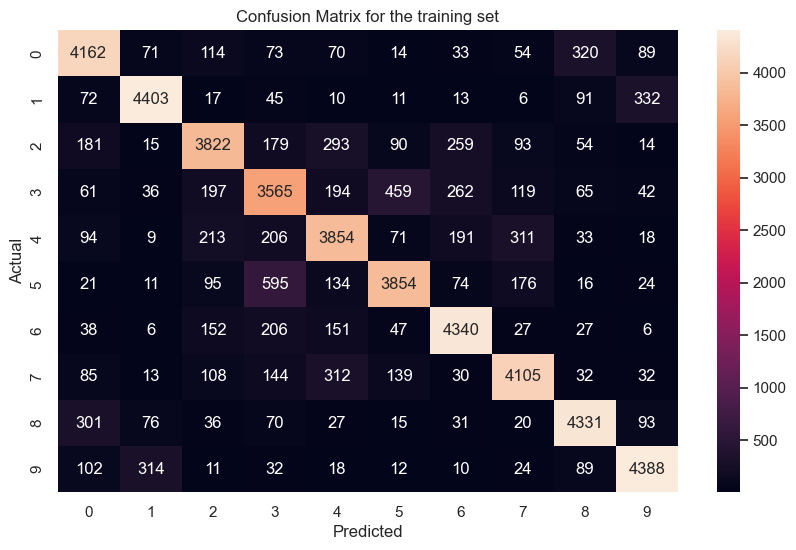

In [42]:
#Confusion Matrix for the training set
y_predtr_numpy = y_predtr.data.cpu().numpy()
y_train_numpy = y_true_train.data.cpu().numpy()
cm_train = confusion_matrix(y_train_numpy, y_predtr_numpy)
plt.subplots(figsize=(10, 6))
sb.heatmap(cm_train, annot = True, fmt = 'g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for the training set")
plt.show()



In [43]:
print(f1_score(y_train_numpy, y_predtr_numpy, average='weighted'))

0.8164026298497084


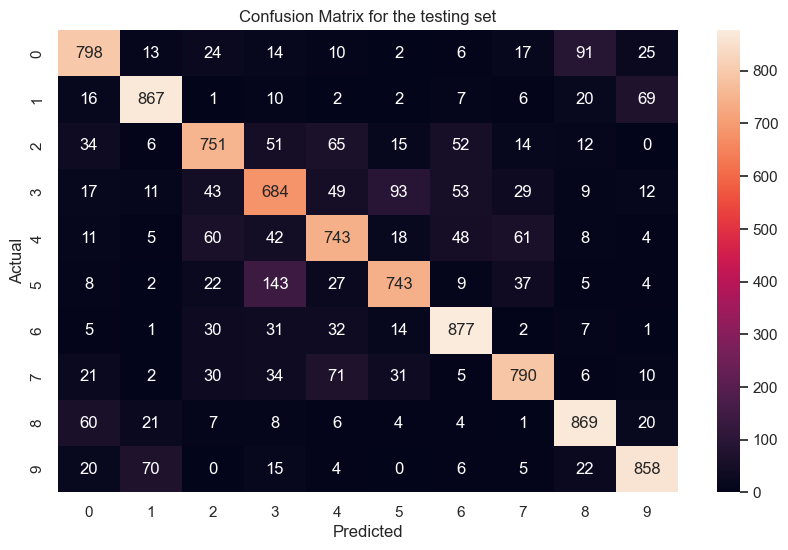

In [46]:
#Confusion Matrix for the test set
y_predts_numpy = y_predts.data.cpu().numpy()
y_test_numpy = y_true_test.data.cpu().numpy()
cm_train = confusion_matrix(y_test_numpy, y_predts_numpy)
plt.subplots(figsize=(10, 6))
sb.heatmap(cm_train, annot = True, fmt = 'g')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for the testing set")
plt.show()

In [47]:
print(f1_score(y_test_numpy, y_predts_numpy, average='weighted'))

0.7977949185941594


Text(0.5, 0, 'Epoch')

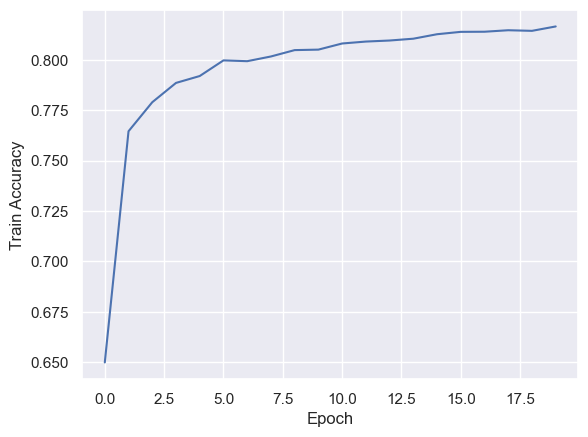

In [55]:
# train acc 
sb.set_theme(style="darkgrid")
sb.lineplot(x=range(0,20), y=train_acc)
plt.ylabel('Train Accuracy')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

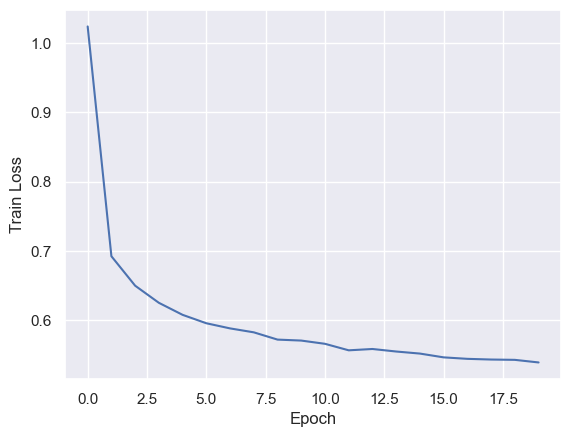

In [56]:
sb.lineplot(x=range(epochs), y=train_loss)
plt.ylabel('Train Loss')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

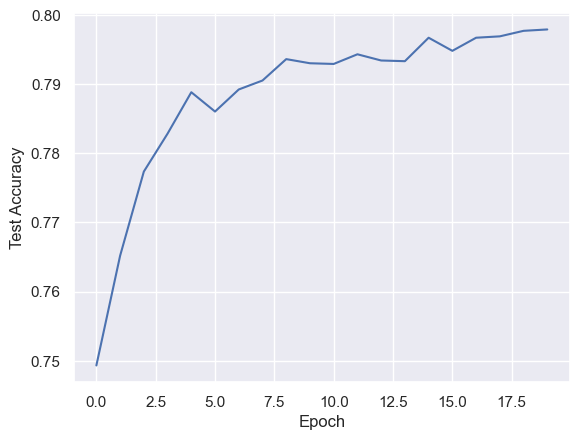

In [57]:
# test acc 
sb.set_theme(style="darkgrid")
sb.lineplot(x=range(0,20), y=test_acc)
plt.ylabel('Test Accuracy')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

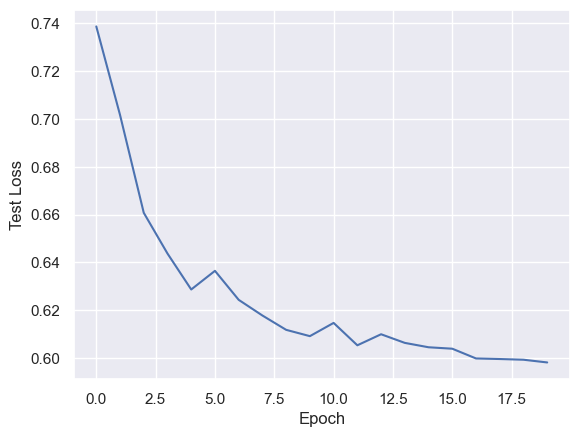

In [59]:
# train acc 
sb.set_theme(style="darkgrid")
sb.lineplot(x=range(0,20), y=test_loss)
plt.ylabel('Test Loss')
plt.xlabel('Epoch')
